## Loading and Visualizing Stellar Catalog

In [12]:
%matplotlib inline

Tools used:

1. pandas

In [36]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

I have downloaded the coordinate for stars from [this post](http://allthingsgraphed.com/2014/12/05/stellar-navigation-using-network-analysis/#data).

Using pandas I can load the data into DataFrame.

In [2]:
stars=pd.read_csv('assets/stars.csv')

I need to know what unit they are using. So I sort the data frame according to distance. The result shows that GI551, which is proxima centari, is 4.226 distance away from Sun. Then I know the unit is lightyear.

In [5]:
stars.sort_values('dist', ascending=True)

,#Name,x-pos,y-pos,z-pos,dist,bright,temp
0,Sun,0.0000,0.0000,0.0000,0.0000,1.0000,5778.4237
78,Gl-551,2.9331,-3.0390,0.1443,4.2260,0.0001,3356.3732
97,Gl-559A,3.1203,-3.0371,0.0539,4.3547,1.5417,5815.2137
96,Gl-559B,3.1203,-3.0371,0.0539,4.3547,0.4529,5162.9390
1078,Gl-699,4.9811,2.9792,-1.4457,5.9814,0.0004,3464.9272
1141,Gl-406,-1.8978,-3.9022,-6.4784,7.7974,0.0000,3169.3537
1722,Gl-411,-3.4014,-0.2952,-7.4659,8.2095,0.0056,3778.5271
636,Gl-65A,-2.1037,0.1698,8.3034,8.5675,0.0001,3333.1966
657,Gl-244A,-5.7538,-6.2178,1.3229,8.5742,40.179110125.2372,NaN
656,Gl-244B,-5.7538,-6.2178,1.3229,8.5742,0.004710515.5618,NaN


To have a sense of the distribution, we can plot some histograms.

But I need to select the distance col first.

In [22]:
stars['dist'].sort_values()

0        0.0000
78       4.2260
97       4.3547
96       4.3547
1078     5.9814
1141     7.7974
1722     8.2095
636      8.5675
657      8.5742
656      8.5742
538      9.5621
1848    10.3347
783     10.6729
1000    10.8324
677     11.0827
1845    11.2664
1844    11.2664
138     11.2898
1761    11.2977
1762    11.2977
2058    11.4003
2059    11.4003
670     11.4043
1098    11.4123
384     11.4725
1531    11.8261
649     12.1976
1101    12.3360
344     12.6127
275     12.6273
         ...   
723     74.1280
776     74.1280
755     74.1280
883     74.1280
1282    74.1280
746     74.1280
360     74.1280
1506    74.1280
1155    74.1280
1799    74.1280
2069    74.2969
1978    74.2969
1675    74.2969
472     74.2969
1526    74.4665
2028    74.4665
389     74.4665
1755    74.4665
1515    74.4665
62      74.6369
1126    74.6369
1125    74.6369
1646    74.6369
640     74.6369
1176    74.8081
675     74.8081
1453    74.9801
1934    74.9801
1933    74.9801
210     74.9801
Name: dist, dtype: float

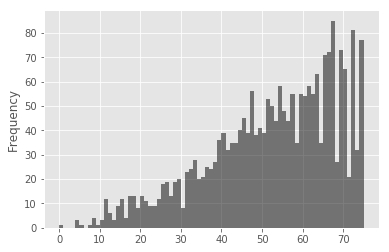

In [40]:
plt.figure();

plotstarshist=stars['dist'].plot.hist(color='k', alpha=0.5, bins=75, range=[0, 75])

which is an expected histogram in general since the differential volume for larger distances becomes larger.

I could also calculate the relative distances between each other.

I can write a function that calculates the distances.

In [ ]:
distance_rel = lambda columnx, columny, columnz: pd.np.linalg.norm(columnx, columny, columnz)